In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
# pd.set_option('display.max_columns', 1000)
# pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('..')

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from project.ranker.ranker import RankingPredictor

In [3]:
%%time
from sklearn.model_selection import train_test_split
rp = Pipeline([
    ('scale', StandardScaler()),
    ('estimator', RankingPredictor("ma_100", n_neighbors=15)),
])
df_mf, df_rank, df_scores = rp.named_steps['estimator'].get_data()

X, _, y, _, y_scores, _ = train_test_split(df_mf.values,
                                           df_rank.values,
                                           df_scores.values,
                                           test_size=0,
                                           random_state=42)
print(X.shape, y.shape, y_scores.shape)

(60, 39) (60, 13) (60, 13)
CPU times: user 1min, sys: 4.6 s, total: 1min 4s
Wall time: 1min 6s


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler

class RankDataset(Dataset):
    def __init__(self, X_cont, X_cats, y):
        super().__init__()
        self.X_cont = X_cont.astype(np.float32)
        self.X_cats = X_cats.astype(np.int64)
        self.y = y.astype(np.float32) # 0-1
        
        self.mf_sz = X_cont.shape[1]
        self.fs_sz = len(np.unique(X_cats))
        
    def __len__(self):
        return len(self.X_cont)
    
    def __getitem__(self, idx):
        return [self.X_cont[idx], self.X_cats[idx], self.y[idx]]

In [5]:
import torch.nn as nn
from torch import optim
from project.ranker.neural_ranker import RankNet
from scipy.stats import rankdata

class NeuralNetwork():
    def __init__(self, mf_sz, fs_sz, params):
        self.mf_sz, self.fs_sz = mf_sz, fs_sz
        self.latent_sz = params['latent_sz']
        self.epochs = params['epochs']
        self.lr = params['learning_rate']
        
        self.model = RankNet(mf_sz, fs_sz, self.latent_sz)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()
        
    def train(self, dl):
        train_losses = []
        for epoch in range(self.epochs):
            train_loss = 0
            for X_cont, X_cats, y in dl:
                train_loss += self.train_step(X_cont, X_cats, y)
            train_losses.append(train_loss) 
        return train_losses
    
    def train_step(self, X_cont, X_cats, y):
        self.model.train()
        self.optimizer.zero_grad()
        preds = self.model(X_cont, X_cats)
        loss = self.criterion(preds.view(-1), y)
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
    def predict(self, dl):
        preds = []
        self.model.eval()
        for X_cont, X_cats, y in dl:
            X_cont.requires_grad_(False)
            X_cats.requires_grad_(False)
            
            pred = self.model(X_cont, X_cats).cpu().detach().numpy()
            preds.extend(pred)
        return np.array([rankdata(x, method='ordinal') for x in \
                         np.reshape(preds, (-1, self.fs_sz))]).astype(int)

In [6]:
def wide2long(X, y):
    n_samples, n_classes = y.shape
    X_cont = np.repeat(X, n_classes, axis=0)
    X_cats = np.array(list(range(n_classes)) * n_samples)
    return X_cont, X_cats.astype(int), y.reshape(-1)

In [7]:
from project.utils.metrics import evaluate_metric

def cv_neuralnet(X, y, y_scores, kfolds, params, verbose_folds=False):
    results = []
    models = []
    X = StandardScaler().fit_transform(X)
    y = (y - y.min()) / (y.max() - y.min())
    for idx, (trn_idx, val_idx) in enumerate(kfolds.split(X, y)):
        X_trn, y_trn, y_scores_trn = X[trn_idx], y[trn_idx], y_scores[trn_idx]
        X_val, y_val, y_scores_val = X[val_idx], y[val_idx], y_scores[val_idx]
        
        X_trn_cont, X_trn_cats, y_trn_long = wide2long(X_trn, y_trn)
        X_val_cont, X_val_cats, y_val_long = wide2long(X_val, y_val)
        
        trn_ds = RankDataset(X_trn_cont, X_trn_cats, y_trn_long)
        val_ds = RankDataset(X_val_cont, X_val_cats, y_val_long)
        
        neuralnet = NeuralNetwork(trn_ds.mf_sz, trn_ds.fs_sz, params)
        trn_dl = DataLoader(trn_ds, batch_size=params['batch_sz'], shuffle=True)
        neuralnet.train(trn_dl)
        
        trn_dl = DataLoader(trn_ds, batch_size=params['batch_sz'], shuffle=False)
        val_dl = DataLoader(val_ds, batch_size=params['batch_sz'], shuffle=False)
        
        y_pred_trn = neuralnet.predict(trn_dl)
        y_pred_val = neuralnet.predict(val_dl)
        
        trn_spearman = evaluate_metric("spearman", y_trn, y_pred_trn)
        trn_acc_loss = evaluate_metric("mean_acc_loss", y_scores_trn, y_pred_trn)
        val_spearman = evaluate_metric("spearman", y_val, y_pred_val)
        val_acc_loss = evaluate_metric("mean_acc_loss", y_scores_val, y_pred_val)
        
        if verbose_folds:
            print(f'Fold {idx + 1:>3} | '
                  f'Trn_Spearman: {trn_spearman: .4f} | '
                  f'Val_Spearman: {val_spearman: .4f} | '
                  f'Trn_ACCLoss: {trn_acc_loss: .4f} | '
                  f'Val_ACCLoss: {val_acc_loss: .4f}')
            
        results.append((trn_spearman, val_spearman, 
                        trn_acc_loss, val_acc_loss))
        models.append(neuralnet)
        
#         break # 1-fold
          
    results = np.array(results)
    print()
    print(f'Trn_Spearman: {results[:,0].mean(): .4f} +/-{results[:,0].std():.4f} | '
          f'Val_Spearman: {results[:,1].mean(): .4f} +/-{results[:,1].std():.4f}\n'
          f'Trn_ACCLoss:  {results[:,2].mean(): .4f} +/-{results[:,2].std():.4f} | '
          f'Val_ACCLoss:  {results[:,3].mean(): .4f} +/-{results[:,3].std():.4f}')
    print()
    return results, models

Next set of params..... {'latent_sz': 30, 'batch_sz': 3, 'epochs': 50, 'learning_rate': 0.0006260860555585102}

Trn_Spearman:  0.7525 +/-0.0128 | Val_Spearman:  0.2228 +/-0.1453
Trn_ACCLoss:   0.0245 +/-0.0040 | Val_ACCLoss:   0.0924 +/-0.0526

Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 530.1786
Function value obtained: 0.0924

Next set of params..... {'latent_sz': 30, 'batch_sz': 40, 'epochs': 29, 'learning_rate': 0.0023670978180025}

Trn_Spearman:  0.7219 +/-0.0134 | Val_Spearman:  0.2374 +/-0.1504
Trn_ACCLoss:   0.0289 +/-0.0040 | Val_ACCLoss:   0.0908 +/-0.0486

Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 42.5270
Function value obtained: 0.0908

Next set of params..... {'latent_sz': 30, 'batch_sz': 20, 'epochs': 43, 'learning_rate': 0.0017902338191623233}

Trn_Spearman:  0.7426 +/-0.0126 | Val_Spearman:  0.2303 +/-0.1365
Trn_ACCLoss:   0.0257 +/-0.0040 | Val_ACCLoss:   0.0927 +/-0.0517

Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 99.7439
Function value obtained: 0.0927

In [8]:
%%time
import lightgbm
from sklearn.model_selection import RepeatedKFold
kfolds = RepeatedKFold(10, n_repeats=10, random_state=42)
params = {'latent_sz': 30, 'batch_sz': 40, 'epochs': 29, 
          'learning_rate': 0.0023670978180025}
results, models = cv_neuralnet(X, y, y_scores, kfolds, params, 
                               verbose_folds=True)

Fold   1 | Trn_Spearman:  0.7145 | Val_Spearman:  0.3233 | Trn_ACCLoss:  0.0337 | Val_ACCLoss:  0.0876
Fold   2 | Trn_Spearman:  0.7105 | Val_Spearman:  0.1026 | Trn_ACCLoss:  0.0184 | Val_ACCLoss:  0.2010
Fold   3 | Trn_Spearman:  0.7453 | Val_Spearman:  0.0321 | Trn_ACCLoss:  0.0298 | Val_ACCLoss:  0.0660
Fold   4 | Trn_Spearman:  0.7109 | Val_Spearman:  0.2418 | Trn_ACCLoss:  0.0288 | Val_ACCLoss:  0.0991
Fold   5 | Trn_Spearman:  0.7172 | Val_Spearman:  0.2289 | Trn_ACCLoss:  0.0354 | Val_ACCLoss:  0.0570
Fold   6 | Trn_Spearman:  0.7187 | Val_Spearman:  0.3883 | Trn_ACCLoss:  0.0268 | Val_ACCLoss:  0.1182
Fold   7 | Trn_Spearman:  0.7209 | Val_Spearman:  0.1914 | Trn_ACCLoss:  0.0280 | Val_ACCLoss:  0.1516
Fold   8 | Trn_Spearman:  0.7285 | Val_Spearman:  0.1264 | Trn_ACCLoss:  0.0252 | Val_ACCLoss:  0.0871
Fold   9 | Trn_Spearman:  0.7150 | Val_Spearman:  0.2179 | Trn_ACCLoss:  0.0289 | Val_ACCLoss:  0.0712
Fold  10 | Trn_Spearman:  0.7360 | Val_Spearman:  0.1841 | Trn_ACCLoss:  

In [13]:
acc = pd.read_csv('results/ACC_scores.csv')
acc['Neural Net'] = results[:,3]

In [14]:
acc.to_csv('results/results_neuralnet.csv', index=False)

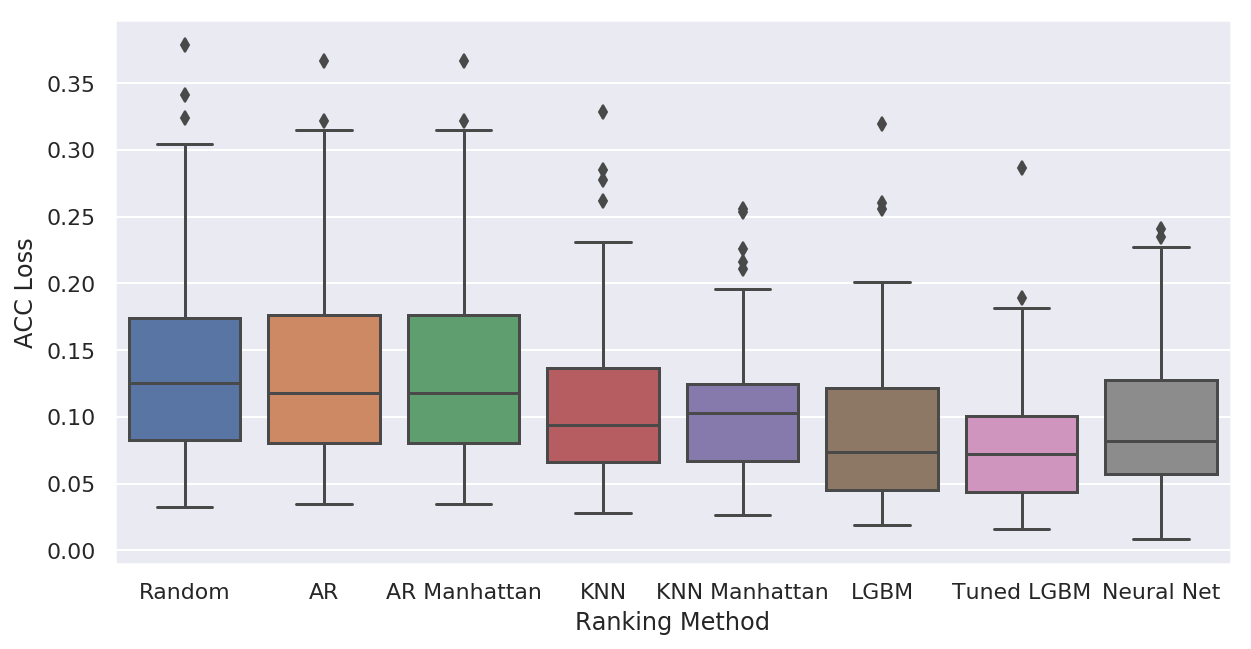

In [15]:
acc = pd.melt(acc, value_vars=['Random', 'AR', 'AR Manhattan', 'KNN', 
                               'KNN Manhattan', 'LGBM', 'Tuned LGBM', 'Neural Net'], 
              var_name='Ranking Method', value_name='ACC Loss')

fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x='Ranking Method', y='ACC Loss', data=acc)

In [16]:
%%time
import lightgbm
from sklearn.model_selection import RepeatedKFold
kfolds = RepeatedKFold(10, n_repeats=10, random_state=42)
params = {'latent_sz': 40, 'batch_sz': 40, 'epochs': 29, 
          'learning_rate': 0.0023670978180025}
results, models = cv_neuralnet(X, y, y_scores, kfolds, params, 
                               verbose_folds=True)

Fold   1 | Trn_Spearman:  0.7251 | Val_Spearman:  0.2885 | Trn_ACCLoss:  0.0319 | Val_ACCLoss:  0.0778
Fold   2 | Trn_Spearman:  0.7189 | Val_Spearman:  0.0650 | Trn_ACCLoss:  0.0183 | Val_ACCLoss:  0.2213
Fold   3 | Trn_Spearman:  0.7662 | Val_Spearman: -0.0238 | Trn_ACCLoss:  0.0267 | Val_ACCLoss:  0.0671
Fold   4 | Trn_Spearman:  0.7160 | Val_Spearman:  0.2509 | Trn_ACCLoss:  0.0319 | Val_ACCLoss:  0.0853
Fold   5 | Trn_Spearman:  0.7206 | Val_Spearman:  0.2509 | Trn_ACCLoss:  0.0330 | Val_ACCLoss:  0.0539
Fold   6 | Trn_Spearman:  0.7303 | Val_Spearman:  0.3755 | Trn_ACCLoss:  0.0255 | Val_ACCLoss:  0.0846
Fold   7 | Trn_Spearman:  0.7392 | Val_Spearman:  0.1832 | Trn_ACCLoss:  0.0286 | Val_ACCLoss:  0.1711
Fold   8 | Trn_Spearman:  0.7373 | Val_Spearman:  0.2289 | Trn_ACCLoss:  0.0260 | Val_ACCLoss:  0.0706
Fold   9 | Trn_Spearman:  0.7168 | Val_Spearman:  0.2179 | Trn_ACCLoss:  0.0260 | Val_ACCLoss:  0.0605
Fold  10 | Trn_Spearman:  0.7440 | Val_Spearman:  0.1429 | Trn_ACCLoss:  